Nicolas Stucky, Elisabeth Sisarith

# Projet Introduction au TAL

## Préparation

### Importation

In [1]:
import pandas as pd
import random

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import CountVectorizer

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import string

### Séparation test et entrainement

In [2]:
# train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# train_df.to_csv('../data/train.csv', index=False)
# test_df.to_csv('../data/test.csv', index=False)


### Ouvrir les csv qui ont déjà été divisés

In [3]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

## Variables

In [4]:
x_train = train_df['recette']
y_train = train_df['type']
y_test = test_df['type']

# Baseline 

### Prédiction aléatoire

Nous prédisons aléatoirement un type. Si le modèle obtient un score plus faible que l'aléatoire, cela signifie qu'il est mauvais.

In [5]:
def random_prediction():
    return random.choice(['Plat principal', 'Entrée', 'Dessert'])

test_df['random prediction'] = test_df.apply(lambda x: random_prediction(), axis=1)


### Prédiction classe majoritaire

Nous prédisons le type qui est apparu le plus de fois dans les données d'entraînement.

In [6]:
def main_class_prediction(train_df):
    main_type = train_df['type'].mode()    
    return main_type

main_type = main_class_prediction(train_df)
test_df['main class prediction'] = test_df.apply(lambda x: main_type, axis=1)

# Normalisation

Nous vérifions si une normalisation du texte influe sur le résultat. Ici, nous normalisons les recettes en :
- mettant tout en minuscules,
- retirant la ponctuation,
- vectorisant les mots pour retirer les mots vides et les lemmatiser.

In [7]:
# Télécharger les ressources nécessaires pour nltk (la première fois seulement)
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

def normalize_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('french'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    normalized_text = ' '.join(tokens)
    return normalized_text

# Ajout d'une colonne avec les recettes normalisées au DataFrame
train_df['recette_normalized'] = train_df['recette'].apply(normalize_text)

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


# Modèle

In [8]:
def prediction(x_train, y_train, test_df, classifier, column_name, normalize=False):
    
    model = make_pipeline(TfidfVectorizer(), classifier)
    model.fit(x_train, y_train)
    if normalize:
        y_pred = model.predict(test_df['recette_normalized'])
    else:
        y_pred = model.predict(test_df['recette'])
    test_df[column_name] = y_pred

    return y_pred

### Naive Bayes Multinomial (sans normalisation)

In [9]:
y_pred_MultNB = prediction(x_train, y_train, test_df, MultinomialNB(), 'Tfi-Df prediction')

### Naive Bayes Multinomial (avec normalisation)

In [10]:
y_pred_MultNB_normalized = prediction(train_df['recette_normalized'], y_train, test_df, MultinomialNB(), 'Tfi-Df prediction N')

### Forêt d’arbres de décision (Random Forest)

In [11]:
y_pred_rf = prediction(x_train, y_train, test_df, RandomForestClassifier(), 'RandomForest Prediction')


### Réseau de neurones

In [12]:
# Prétraitement des données
vectorizer = CountVectorizer()
x_train_counts = vectorizer.fit_transform(x_train)
x_test_counts = vectorizer.transform(test_df['recette'])

# Convertion des étiquettes en format numérique
label_to_idx = {'Entrée': 0, 'Plat principal': 1, 'Dessert': 2}
y_train_idx = [label_to_idx[label] for label in y_train]

# Définition du modèle
class RecipeClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RecipeClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

input_size = x_train_counts.shape[1]
hidden_size = 100
num_classes = 3
model = RecipeClassifier(input_size, hidden_size, num_classes)

# Définition de la fonction de perte et de l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entraînement du modèle
num_epochs = 10
for epoch in range(num_epochs):
    inputs = torch.tensor(x_train_counts.toarray(), dtype=torch.float32)
    labels = torch.tensor(y_train_idx, dtype=torch.long)
    
    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print("Epoch [", epoch+1, "/", num_epochs, "]")

# Évaluation du modèle
with torch.no_grad():
    inputs = torch.tensor(x_test_counts.toarray(), dtype=torch.float32)
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    predicted_labels = [list(label_to_idx.keys())[list(label_to_idx.values()).index(idx)] for idx in predicted]

test_df['Neural Network prediction'] = predicted_labels


Epoch [ 1 / 10 ]
Epoch [ 2 / 10 ]
Epoch [ 3 / 10 ]
Epoch [ 4 / 10 ]
Epoch [ 5 / 10 ]
Epoch [ 6 / 10 ]
Epoch [ 7 / 10 ]
Epoch [ 8 / 10 ]
Epoch [ 9 / 10 ]
Epoch [ 10 / 10 ]


### SVC

In [13]:
y_pred_SVC = prediction(x_train, y_train, test_df, SVC(), 'SVC prediction')


# Résultat

In [14]:
def results(y_model, y_test, title=''):

    classes = ['Entrée', 'Plat principal', 'Dessert']
    conf_matrix = confusion_matrix(y_test, y_model, labels=classes)

    conf_df = pd.DataFrame(conf_matrix, columns=classes, index=classes)

    print("Matrice de Confusion : \n")

    plt.figure(figsize=(8,6))
    sns.heatmap(conf_df, annot=True, cmap="YlGnBu", fmt='g')
    plt.title('Matrice de Confusion : ' + title)
    plt.xlabel('Prédictions')
    plt.ylabel('Valeurs Réelles')
    plt.show()

    # Rappel - Precision - F1-score

    report = classification_report(y_test, y_model)
    print(report)

### Aléatoire

Matrice de Confusion : 



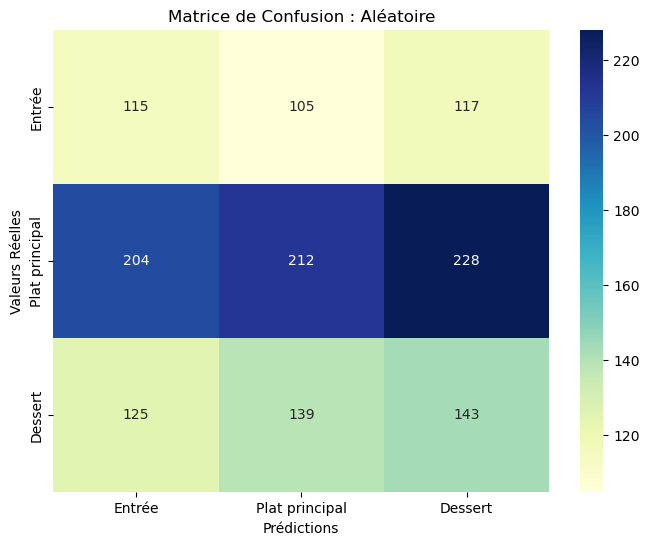

                precision    recall  f1-score   support

       Dessert       0.29      0.35      0.32       407
        Entrée       0.26      0.34      0.29       337
Plat principal       0.46      0.33      0.39       644

      accuracy                           0.34      1388
     macro avg       0.34      0.34      0.33      1388
  weighted avg       0.36      0.34      0.34      1388



In [15]:
y_rand = test_df['random prediction']
results(y_rand, y_test, 'Aléatoire')

On peut voir sur cette heatmap qu'avec l'aléatoire, les cases ont une valeur relativement similaire. Le fait que la ligne des plats soit en bleu foncé signifie seulement que les données contiennent plus de plat que des autres types.

En ce qui concerne les mesures, elles sont toutes inférieurs à 0.4.

### Classe majoritaire

Matrice de Confusion : 



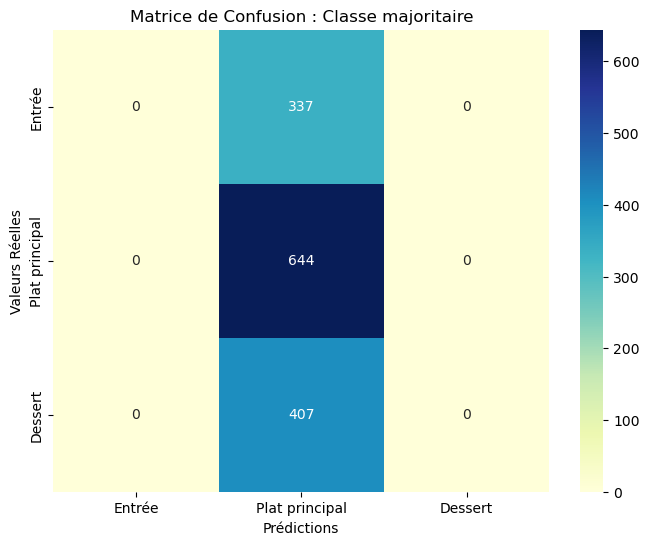

                precision    recall  f1-score   support

       Dessert       0.00      0.00      0.00       407
        Entrée       0.00      0.00      0.00       337
Plat principal       0.46      1.00      0.63       644

      accuracy                           0.46      1388
     macro avg       0.15      0.33      0.21      1388
  weighted avg       0.22      0.46      0.29      1388



c:\Users\Nicolas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nicolas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Nicolas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
y_main = test_df['main class prediction']
results(y_main, y_test, 'Classe majoritaire')

Le modèle de classe majoritaire a donc toujours prédit "Plat principal", il n'est donc pas étonnant d'avoir un recall de 1 pour ce type et 0 pour les autres, ni d'avoir une précision de 0.46 pour le plat prédit puisqu'il s'agit de la proportion de ce type dans les données. 

La moyenne macro de la f-mesure étant de 0.21, nous pouvons affirmer ce que ce modèle est mauvais puisqu'il est moins efficace que le random, avec son 0.33.

### Naive Bayes Multinomial (sans normalisation)

Matrice de Confusion : 



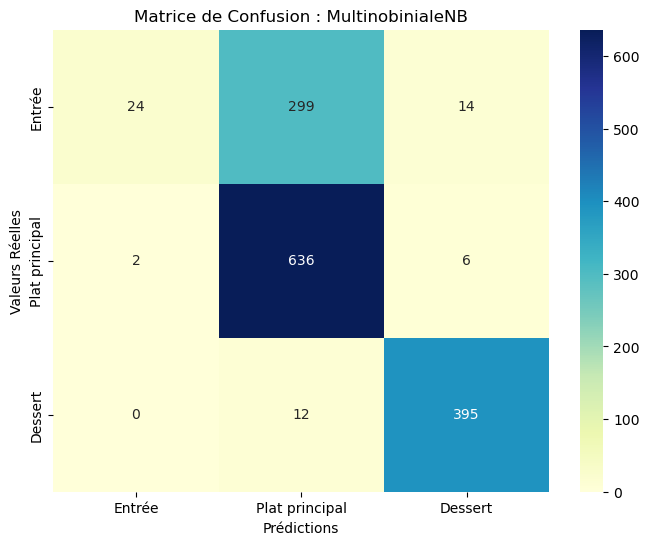

                precision    recall  f1-score   support

       Dessert       0.95      0.97      0.96       407
        Entrée       0.92      0.07      0.13       337
Plat principal       0.67      0.99      0.80       644

      accuracy                           0.76      1388
     macro avg       0.85      0.68      0.63      1388
  weighted avg       0.81      0.76      0.68      1388



In [17]:
results(y_pred_MultNB, y_test, 'MultinobinialeNB')

### Naive Bayes Multinomial (avec normalisation)

Matrice de Confusion : 



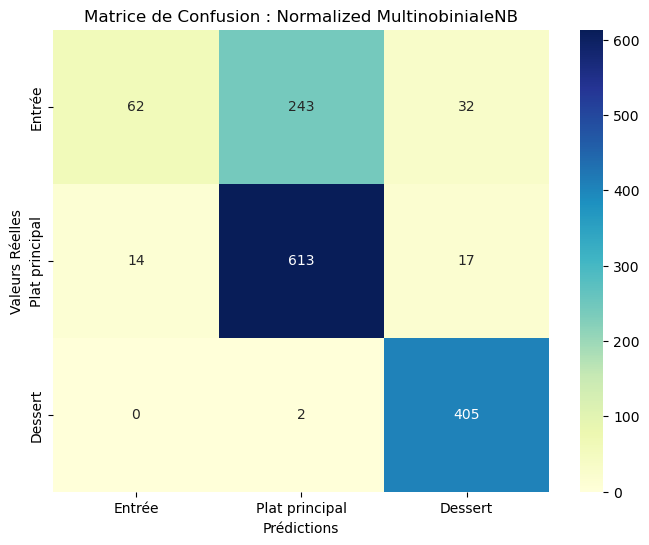

                precision    recall  f1-score   support

       Dessert       0.89      1.00      0.94       407
        Entrée       0.82      0.18      0.30       337
Plat principal       0.71      0.95      0.82       644

      accuracy                           0.78      1388
     macro avg       0.81      0.71      0.69      1388
  weighted avg       0.79      0.78      0.73      1388



In [18]:
results(y_pred_MultNB_normalized, y_test, 'Normalized MultinobinialeNB')

### Comparaison entre normalisé et non normalisé pour Naive Bayes Multinomial

In [19]:
print("Résultat pour Naive Bayes Multinomial non-normalisé:")
print(classification_report(y_test, y_pred_MultNB))

print("Résultat pour Naive Bayes Multinomial normalisé:")
print(classification_report(y_test, y_pred_MultNB_normalized))


Résultat pour Naive Bayes Multinomial non-normalisé:
                precision    recall  f1-score   support

       Dessert       0.95      0.97      0.96       407
        Entrée       0.92      0.07      0.13       337
Plat principal       0.67      0.99      0.80       644

      accuracy                           0.76      1388
     macro avg       0.85      0.68      0.63      1388
  weighted avg       0.81      0.76      0.68      1388

Résultat pour Naive Bayes Multinomial normalisé:
                precision    recall  f1-score   support

       Dessert       0.89      1.00      0.94       407
        Entrée       0.82      0.18      0.30       337
Plat principal       0.71      0.95      0.82       644

      accuracy                           0.78      1388
     macro avg       0.81      0.71      0.69      1388
  weighted avg       0.79      0.78      0.73      1388



Avec la normalisation des recettes, nous pouvons voir que la f-mesure est légèrement améliorée, passant de 0.63 à 0.69. Ces deux modèles sont plus performants que l'aléatoire, mais il y a une marge d'amélioration possible.

L'erreur principale des deux modèles est qu'ils ont tendance à prédire "Plat principal" pour les entrées.

La normalisation permet de couvrir quasiment tous les desserts, cependant, nous remarquons aussi qu'il y a un peu plus de faux positifs pour ce type. Ce défaut est également visible pour les entrées de manière plus atténué, tout comme la petite amélioration du rappel des entrées. 

### Forêt d’arbres de décision (Random Forest)

Matrice de Confusion : 



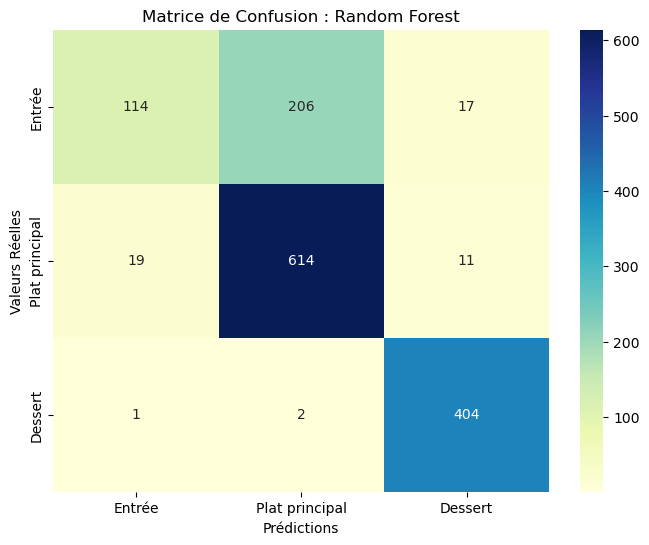

                precision    recall  f1-score   support

       Dessert       0.94      0.99      0.96       407
        Entrée       0.85      0.34      0.48       337
Plat principal       0.75      0.95      0.84       644

      accuracy                           0.82      1388
     macro avg       0.84      0.76      0.76      1388
  weighted avg       0.83      0.82      0.79      1388



In [20]:
results(y_pred_rf, y_test, 'Random Forest')

La f-mesure étant de 0.76, il y a encore une fois une amélioration de classification.

Tout comme les Naive Bayes Multinominaux, le modèle Forêt d’arbres de décision prédit les entrées en plat, mais le fait un peu moins.

### SVC

Matrice de Confusion : 



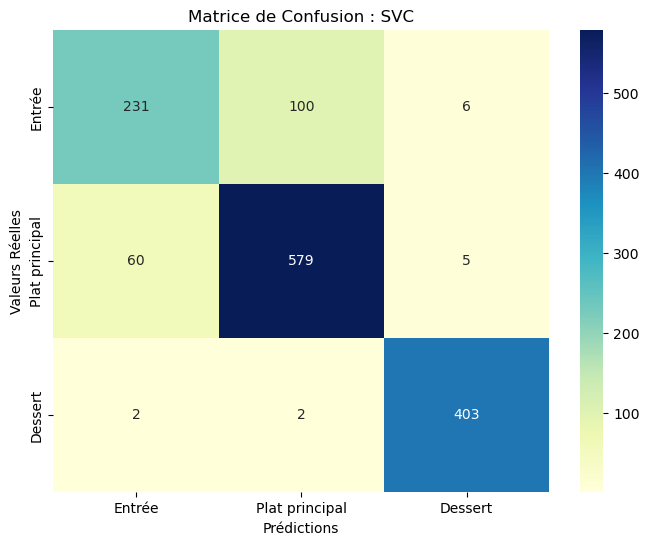

                precision    recall  f1-score   support

       Dessert       0.97      0.99      0.98       407
        Entrée       0.79      0.69      0.73       337
Plat principal       0.85      0.90      0.87       644

      accuracy                           0.87      1388
     macro avg       0.87      0.86      0.86      1388
  weighted avg       0.87      0.87      0.87      1388



In [21]:
results(y_pred_SVC, y_test, 'SVC')

Le modèle SVC est celui qui obtient le meilleur f1-score, qui est de 0.86.

Celui-ci parvient à mettre plus d'entrée dans le bon type. Cette amélioration du rappel s'accompagne d'une légère augmentation de faux positifs aux entrées, ce qui fait baissé sa précision.

### Réseau de neurones

Matrice de Confusion : 



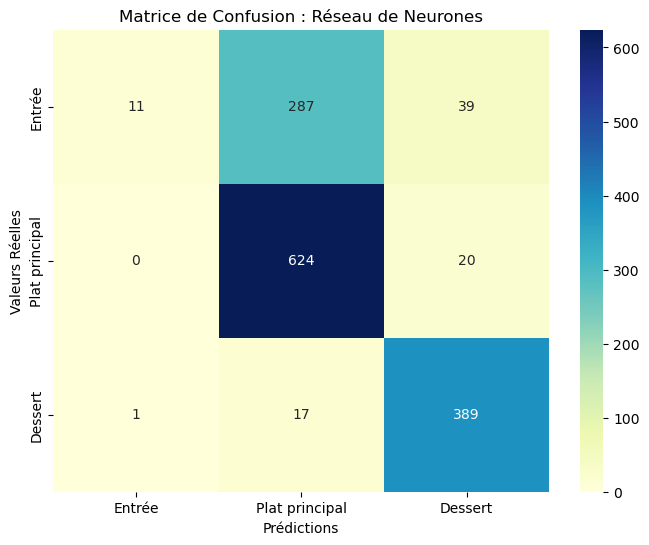

                precision    recall  f1-score   support

       Dessert       0.87      0.96      0.91       407
        Entrée       0.92      0.03      0.06       337
Plat principal       0.67      0.97      0.79       644

      accuracy                           0.74      1388
     macro avg       0.82      0.65      0.59      1388
  weighted avg       0.79      0.74      0.65      1388



In [22]:
results(predicted_labels, y_test, 'Réseau de Neurones')

Avec son f1-score de 0.57, le modèle de réseau de neurones est relativement peu performant, bien que meilleur que l'aléatoire.

Ce modèle ne parvient pas à prédire une entrée, ce qui explique la précision de 1 (il n'y a aucune erreur dans les prédictions d'entrées puisqu'il n'y a pas eu d'entrées prédites). 

Il semblerait que la principale difficulté pour les modèles est de prédire s'il s'agit d'une entrée ou d'un plat. Pour les desserts, les modèles font assez peu d'erreurs.

In [23]:
test_df.to_csv('../data/test_predictions.csv', index=False, columns=['titre', 'type', 'random prediction', 'main class prediction', 'Tfi-Df prediction', 'RandomForest Prediction', 'SVC prediction', 'Neural Network prediction', 'recette'])

# Analyse des erreurs de SVC

Nous avons choisi SVC car c'est le modèle qui a obtenu les meilleures f-mesures.

D'après la heatmap, nous voyons que les erreurs se font majoritairement sur la prédiction des entrées et des plats qui s'inversent. 
Nous essayons donc de trouver des règles qui pourrait améliorer cette classification.

Nous allons analyser les erreurs faites sur les données du train pour éviter d'apprendre sur celles de test, qui servent à l'évaluation.

Nombre d'erreur: 282
Matrice de Confusion : 



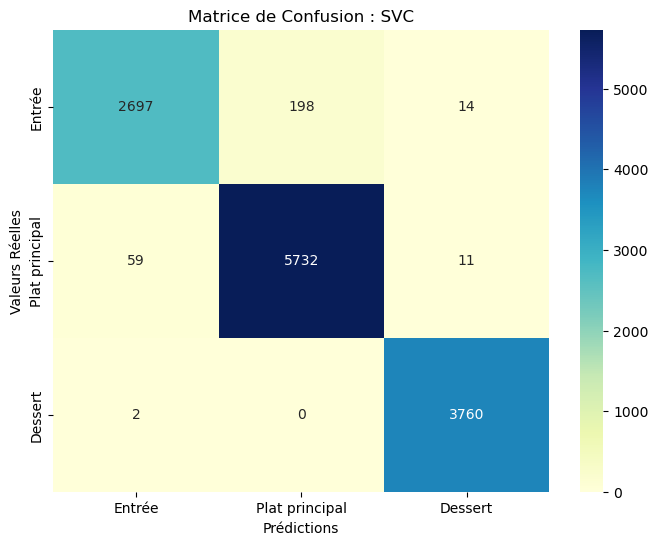

                precision    recall  f1-score   support

       Dessert       0.99      1.00      1.00      3762
        Entrée       0.98      0.93      0.95      2909
Plat principal       0.97      0.99      0.98      5802

      accuracy                           0.98     12473
     macro avg       0.98      0.97      0.98     12473
  weighted avg       0.98      0.98      0.98     12473



In [24]:
y_train_SVC = prediction(x_train, y_train, train_df, SVC(), 'SVC prediction')

erreurs = train_df[(train_df['SVC prediction'] != train_df['type']) & (train_df['type'] != "Dessert")]
print("Nombre d'erreur:", erreurs.shape[0])

results(y_train_SVC, y_train, 'SVC')


Nous avons essayé de chercher des mots dans les titres des recettes qui ont été mal catégorisé dans l'objectif de corriger cela par des règles (par exemple, si l'on trouve "pomme" dans le titre et "four" dans la recette et que ça a été prédit en plat, alors il faut le prédire en entrée).

Nous ne sommes pas parvenus à trouver des règles qui pouvait améliorer les scores car nous trouvions toujours un contre-exemple à la règles que nous voulions écrire.

In [25]:
regex_titre = r'(?i)pomme?s?'
regex_recette = r'(?i)four'

mask_titre = train_df['titre'].str.contains(regex_titre)
mask_recette = train_df['recette'].str.contains(regex_recette)

mask = mask_titre & mask_recette

bonne_pred = train_df[mask & (train_df['SVC prediction'] == train_df['type'])]
mauvaise_pred = train_df[mask & (train_df['SVC prediction'] != train_df['type'])]

print("Nombre de lignes où 'prédiction' est égal à 'type':", bonne_pred.shape[0])
print("Nombre de lignes où 'prédiction' est différent de 'type':", mauvaise_pred.shape[0])


Nombre de lignes où 'prédiction' est égal à 'type': 471
Nombre de lignes où 'prédiction' est différent de 'type': 14


In [26]:
entree = train_df[mask & (train_df['type'] == "Entrée")]
bonne_pred_entree = bonne_pred[(train_df['type'] == "Entrée")]
print("Nombre de bonnes prédictions pour les entrées:", bonne_pred_entree.shape[0], '/', entree.shape[0])

plat = train_df[mask & (train_df['type'] == "Plat principal")]
bonne_pred_plat = bonne_pred[(train_df['type'] == "Plat principal")]
print("Nombre de bonnes prédictions pour les plats principaux:", bonne_pred_plat.shape[0], '/', plat.shape[0])

dessert = train_df[mask & (train_df['type'] == "Dessert")]
bonne_pred_dessert = bonne_pred[(train_df['type'] == "Dessert")]
print("Nombre de bonnes prédictions pour les desserts:", bonne_pred_dessert.shape[0], '/', dessert.shape[0])
print("------")
mauvaise_pred_entree = mauvaise_pred[(train_df['SVC prediction'] == "Entrée")]
print("Nombre de mauvaise prédictions pour les entrées:", mauvaise_pred_entree.shape[0])

mauvaise_pred_plat = mauvaise_pred[(train_df['SVC prediction'] == "Plat principal")]
print("Nombre de mauvaise prédictions pour les plats principaux:", mauvaise_pred_plat.shape[0])

mauvaise_pred_dessert = mauvaise_pred[(train_df['SVC prediction'] == "Dessert")]
print("Nombre de mauvaise prédictions pour les desserts:", mauvaise_pred_dessert.shape[0])

Nombre de bonnes prédictions pour les entrées: 37 / 49
Nombre de bonnes prédictions pour les plats principaux: 146 / 148
Nombre de bonnes prédictions pour les desserts: 288 / 288
------
Nombre de mauvaise prédictions pour les entrées: 2
Nombre de mauvaise prédictions pour les plats principaux: 11
Nombre de mauvaise prédictions pour les desserts: 1


C:\Users\Nicolas\AppData\Local\Temp\ipykernel_22708\3135506729.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bonne_pred_entree = bonne_pred[(train_df['type'] == "Entrée")]
C:\Users\Nicolas\AppData\Local\Temp\ipykernel_22708\3135506729.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bonne_pred_plat = bonne_pred[(train_df['type'] == "Plat principal")]
C:\Users\Nicolas\AppData\Local\Temp\ipykernel_22708\3135506729.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  bonne_pred_dessert = bonne_pred[(train_df['type'] == "Dessert")]
C:\Users\Nicolas\AppData\Local\Temp\ipykernel_22708\3135506729.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mauvaise_pred_entree = mauvaise_pred[(train_df['SVC prediction'] == "Entrée")]
C:\Users\Nicolas\AppData\Local\Temp\ipykernel_22708\3135506729.py:16: UserWarning: Boolean Series key will be reindexed to match DataF

In [27]:
mauvaise_pred.head(min(20, mauvaise_pred.shape[0]))

,doc_id,titre,type,difficulte,cout,ingredients,recette,recette_normalized,SVC prediction
1404,recette_24594.xml,Tortilla de pommes de terre,Entrée,Facile,Bon marché,- 8 oeufs - 3 pommes de terre moyenne - 1 oign...,Pelez et coupez les pommes de terre en petits ...,pelez coupez pommes terre petits cube loignon ...,Plat principal
2321,recette_26012.xml,Daurade aux pommes de terre et tomates farcies,Entrée,Moyennement difficile,Moyen,"- 1 daurade de 1,2 kg ou 2 daurades moyennes -...",Faire préparer la daurade par votre poissonnie...,faire préparer daurade poissonnier faire vider...,Plat principal
4054,recette_12345.xml,Quenelles de pommes de terre,Entrée,Très facile,Bon marché,- 700 g de pommes de terre - 2 oeufs - 2 dl de...,Cuire les pommes de terre en robe des champs 3...,cuire pommes terre robe champ 30 mn env égoutt...,Plat principal
4074,recette_95144.xml,Pommes de terres nouvelles entières au four,Entrée,Très facile,Bon marché,- 1kg de pommes de terres nouvelles ou de peti...,- Préchauffer le four à 180°C Faire fondre le ...,préchauffer four 180°c faire fondre beurre ver...,Plat principal
5575,recette_223778.xml,"Tarte aux pommes de terre, cougettes et lardons",Entrée,Facile,Bon marché,- 1 pâte feuilletée - 3 œufs - 20 cl de crème ...,Faire blanchir les pommes de terre 10 min dans...,faire blanchir pommes terre 10 min leau bouill...,Plat principal
6884,recette_61998.xml,Amuse-gueules pomme boudin noir,Plat principal,Très facile,Bon marché,- 1 paquet pain de mie rond - 2 pommes - beurr...,Préchauffer le four à 190°C (thermostat 6-7). ...,préchauffer four 190°c thermostat 67 beurrer c...,Entrée
8776,recette_68535.xml,Quiche poireaux - pommes de terre,Entrée,Très facile,Bon marché,- 1 pâte à tarte feuilletée - 2 poireaux - 3 ...,Faire cuire les poireaux et les pommes de terr...,faire cuire poireaux pommes terre lautocuiseur...,Plat principal
9297,recette_26831.xml,Terrine de foie gras aux pommes vertes,Plat principal,Très facile,Assez Cher,- un beau foie gras frais - quatre pommes vert...,Dénervez le foie puis le couper en escalopes é...,dénervez foie puis couper escalopes épaisses e...,Entrée
10059,recette_94255.xml,Gratin de tomates sur pommes de terres,Entrée,Facile,Bon marché,- 4 grosses tomates - 6 tranches d'ananas en c...,Eplucher vos pommes de terre et couper les en ...,eplucher pommes terre couper tranche assez épa...,Plat principal
10683,recette_45631.xml,Crêpes au camembert et aux pommes de Normandie,Entrée,Très facile,Assez Cher,- 170 g de farine - 1 sachet de levure chimiqu...,"Dans un saladier, mélanger ensemble : farine, ...",saladier mélanger ensemble farine levure œufs ...,Dessert


In [28]:
bonne_pred.head(min(20, bonne_pred.shape[0]))

,doc_id,titre,type,difficulte,cout,ingredients,recette,recette_normalized,SVC prediction
74,recette_25066.xml,Clafoutis de pommes de terre au chèvre cendré,Plat principal,Facile,Bon marché,- 4 pommes de terre moyennes - 2 oignons - 1 b...,1) Pelez et coupez les pommes de terres en ron...,1 pelez coupez pommes terres rondelles lavez é...,Plat principal
86,recette_51596.xml,Terrine de pommes de terre aux cèpes,Plat principal,Facile,Moyen,- 8 petites pommes de terre - 250 g de petits ...,Préchauffer le four à 175°C (thermostat 5-6). ...,préchauffer four 175°c thermostat 56 nettoyer ...,Plat principal
122,recette_37014.xml,La flognarde aux pommes (ou autres fruits),Dessert,Très facile,Bon marché,- 4 cuillerées à soupe de farine - 3 cuillerée...,"Dans un saladier, mélanger la farine, le sucre...",saladier mélanger farine sucre poudre sel puis...,Dessert
183,recette_82490.xml,Pain d'hachis accompagné de pommes frites,Plat principal,Facile,Bon marché,- 250 g de chair à saucisse - 500 g de viande...,Préchauffer le four à 180°C (thermostat 6). Pr...,préchauffer four 180°c thermostat 6 prendre 1 ...,Plat principal
203,recette_35612.xml,Tarte aux pommes Jean-René,Dessert,Moyennement difficile,Bon marché,- Pour la pâte demi-feuilletée : - 300 g de fa...,"Pour cette recette, il est absolument indispen...",cette recette absolument indispensable prépare...,Dessert
283,recette_66035.xml,"Salade rafraîchissante aux endives, pommes et ...",Plat principal,Très facile,Bon marché,- 6 ou 7 endives selon leur grosseur - 2 pomme...,Ôter et jeter les première feuilles des endive...,ôter jeter première feuilles endive puis coupe...,Plat principal
286,recette_228236.xml,Crumble gourmand au pralin et sa compotée pomm...,Dessert,Facile,Bon marché,- Pour la compotée : - 3 à 4 pommes Golden de ...,Préchauffer le four à 180°C (thermostat 6).Pré...,préchauffer four 180°c thermostat 6préparation...,Dessert
304,recette_27334.xml,Gratin de pommes de terre en béchamel,Plat principal,Facile,Moyen,"- 1,5 kg de pommes de terre - 100 g de beurre ...",Faire cuire les pommes de terre à l'eau enviro...,faire cuire pommes terre leau environ 20 min p...,Plat principal
333,recette_222850.xml,"Pommes de terre écrasées au poireau, fromage d...",Plat principal,Facile,Bon marché,- 600 g de pommes de terre à purée - 3 poireau...,Eplucher les pommes de terre et les couper en ...,eplucher pommes terre couper morceau taille si...,Plat principal
351,recette_35366.xml,Gratin de pomme meringué,Dessert,Facile,Bon marché,- 4 pommes - 150 g de fromage blanc - 3 oeufs ...,"Lavez, épluchez et coupez les pommes en quarti...",lavez épluchez coupez pommes quartiers faites ...,Dessert
